# RAS Sales Analysis

In [1]:
%load_ext autoreload
%autoreload

#%autoreload
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
display(HTML("""<style>div.output_area{max-height:10000px;overflow:scroll;}</style>"""))

import pandas as pd
pd.set_option("display.max_rows",1000)
pd.set_option("display.max_columns",500)
pd.set_option('precision', 3)

from os.path import join
from os import listdir
from glob import glob
from pandas import read_csv, read_excel, Series, DataFrame, to_numeric, concat
from sklearn.externals import joblib
from pandas import crosstab

#import geopandas as gpd

import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

#from pmdarima.arima import auto_arima

In [ ]:
# Notes:

#There is a more recent scenarios. Discuss to Nancy/
# Jeff says Make a New Model. Hold constant at fix share of market * 0.72
#   - Study how to measure market share (Import/Export vs survey vs POS) talk to Nancy about the bias of the various approaches.
#   - GDOs last longer now compared to the last time 
#   - July 11th there is a big meeting for Jeff

In [2]:
import datetime as dt
start = dt.datetime.now()
print("Notebook Last Run Initiated: "+str(start))

Notebook Last Run Initiated: 2019-06-20 09:03:45.316411


In [3]:
def highlight_max(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_max = s == s.max()
    return ['background-color: yellow' if v else '' for v in is_max]

def color_negative_red(val):
    """
    Takes a scalar and returns a string with
    the css property `'color: red'` for negative
    strings, black otherwise.
    """
    color = 'red' if val < 0 else 'black'
    return 'color: %s' % color

# Load Excel Files

In [62]:
files = glob("*Professional Sales*.xlsx")
print(files)
datas = [read_excel(x) for x in files]

ccmap = {}
for i in range(len(datas)):
    data = datas[i].drop([0,1], axis=0)
    data.columns = ["Acct. Channel", "Acct. Sold-To", "Cust.Class", "Cust.Class.Name", "Net Units", "Net Sales"]
    datas[i] = data
    
    keep = datas[i][["Acct. Channel", "Acct. Sold-To", "Cust.Class"]].to_dict()
    accdata = list(keep["Acct. Sold-To"].values())
    ccdata  = list(keep["Cust.Class"].values())
    for i in range(len(ccdata)):

        acc = accdata[i]
        if ccmap.get(acc) is None:
            ccmap[acc] = ccdata[i]

['2017 Professional Sales by Customer.xlsx', '2018 Professional Sales by Customer.xlsx']


In [63]:
len(ccmap)

3849

In [60]:
ccmap

{'CONSUMER CREDIT CARD ORDERS': '#',
 'DEALER EXTRANET GUEST CA': '#',
 'DEALER EXTRANET GUEST US': '#',
 'GENTEX CORP': 'IA',
 'SEARS IN WARRANTY N/C PARTS': '#',
 'BENJAMIN POITEVIN': 'IA',
 'CHAMBERLAIN EMPLOYEE ACCOMMODATION': '#',
 'CHAMBERLIN EMPLOYEE ACCOMMODATION': '#',
 'GDO RETAIL CANADA MARKETING': '#',
 'GDO RETAIL MARKETING': '#',
 'INTERMATIC INC': '#',
 'LIFTMASTER GATE ONE TIME SALES': '#',
 'LIFTMASTER GDO CANADA MARKETING': 'IA',
 'LIFTMASTER GDO MARKETING': 'IA',
 'LIFTMASTER GDO ONE TIME SALES': '#',
 'LIFTMASTER IPAC BILLING': 'IA',
 '002626375 ONT INC': '#',
 '0848982 BC LTD': '#',
 '0951036 BC LTD': '#',
 '1 SOURCE MATERIAL HANDLING LLC': '#',
 '1021350 ONTARIO LIMITED': '#',
 '1275455 ALBERTA LTD': '#',
 '1460119 ALBERTA LTD': '#',
 '1584232 ALBERTA INC': '#',
 '1603052 AB LTD': '#',
 '1668146 ONTARIO INC': '#',
 '1923186 ONT LTD': '#',
 '1ST CALL GARAGE DOORS LLC': '#',
 '1ST GARAGE DOOR OPENERS INC': '#',
 '1ST UNITED DOOR TECHNOLOGIES LLC': '#',
 '2014792 ONT

In [4]:
files = glob("NET_SALES_SUMMARY_*.xlsx")
print(files)
datas = [read_excel(x) for x in files]

for i in range(len(datas)):
    coldata = list(datas[i].loc[1].values[:6]) + list(datas[i].loc[1].index[6:])
    coldata[2] = "Region Name"
    data = datas[i].drop([0,1], axis=0)
    data.columns = coldata
    data.fillna(0, inplace=True)
    datas[i] = data

# Remove June 2019
datas[0].drop([x for x in datas[0].columns if x.endswith(".5")], axis=1, inplace=True)
    
months = pd.date_range('2019-01-01','2019-06-01', freq='M').strftime("%Y-%b").tolist()
units = ["Net Units {0}".format(m) for m in months]
sales = ["Net Sales {0}".format(m) for m in months]
coldata = list(datas[0].columns)[:6]
coldata = coldata + units + sales
datas[0].columns = coldata
datas[0].index = datas[0][['State/Province', 'Acct. Sold-To', 'Acct. Channel', 'Profit.Ctr', 'Sls.Reg', 'Region Name']].apply(lambda x: ' :: '.join(str(y) for y in x), axis=1)
datas[0].drop(['State/Province', 'Acct. Sold-To', 'Acct. Channel', 'Profit.Ctr', 'Sls.Reg', 'Region Name'], axis=1, inplace=True)

months = pd.date_range('2017-01-01','2018-01-01', freq='M').strftime("%Y-%b").tolist()
units = ["Net Units {0}".format(m) for m in months]
sales = ["Net Sales {0}".format(m) for m in months]
coldata = list(datas[1].columns)[:6]
coldata = coldata + units + sales
datas[1].columns = coldata
datas[1].index = datas[1][['State/Province', 'Acct. Sold-To', 'Acct. Channel', 'Profit.Ctr', 'Sls.Reg', 'Region Name']].apply(lambda x: ' :: '.join(str(y) for y in x), axis=1)
datas[1].drop(['State/Province', 'Acct. Sold-To', 'Acct. Channel', 'Profit.Ctr', 'Sls.Reg', 'Region Name'], axis=1, inplace=True)

months = pd.date_range('2018-01-01','2019-01-01', freq='M').strftime("%Y-%b").tolist()
units = ["Net Units {0}".format(m) for m in months]
sales = ["Net Sales {0}".format(m) for m in months]
coldata = list(datas[2].columns)[:6]
coldata = coldata + units + sales
datas[2].columns = coldata
datas[2].index = datas[2][['State/Province', 'Acct. Sold-To', 'Acct. Channel', 'Profit.Ctr', 'Sls.Reg', 'Region Name']].apply(lambda x: ' :: '.join(str(y) for y in x), axis=1)
datas[2].drop(['State/Province', 'Acct. Sold-To', 'Acct. Channel', 'Profit.Ctr', 'Sls.Reg', 'Region Name'], axis=1, inplace=True)

print(datas[0].shape)
print(datas[1].shape)
data = datas[0].join(datas[1], how="outer")
print(data.shape)
print(datas[2].shape)
data = data.join(datas[2], how="outer")
print(data.shape)

salescols = [x for x in data.columns if x.startswith("Net Sales")]
salesdata = data[salescols]
unitcols  = [x for x in data.columns if x.startswith("Net Units")]
unitdata  = data[unitcols]

salesdata["State/Province"] = [x[0] for x in list(salesdata.index.str.split(' :: '))]
salesdata["Acct. Sold-To"]  = [x[1] for x in list(salesdata.index.str.split(' :: '))]
salesdata["Acct. Channel"]  = [x[2] for x in list(salesdata.index.str.split(' :: '))]
salesdata["Profit.Ctr"]     = [x[3] for x in list(salesdata.index.str.split(' :: '))]
salesdata["Sls.Reg"]        = [x[4] for x in list(salesdata.index.str.split(' :: '))]
salesdata["Region Name"]    = [x[5] for x in list(salesdata.index.str.split(' :: '))]

cols = [x.replace("Net Sales ", "") for x in salesdata.columns]
salesdata.columns = cols
scols = sorted(cols)
salesdata = salesdata[scols]

from datetime import datetime
cols = [datetime.strptime(x, '%Y-%b') for x in list(salesdata.columns)[:-6]] + list(salesdata.columns)[-6:]
salesdata.columns = cols
cols = list(salesdata.columns)[-6:] + sorted(list(salesdata.columns)[:-6])
salesdata = salesdata[cols]
salesdata.drop(salesdata.index[0], axis=0, inplace=True)

unitdata["State/Province"] = [x[0] for x in list(unitdata.index.str.split(' :: '))]
unitdata["Acct. Sold-To"]  = [x[1] for x in list(unitdata.index.str.split(' :: '))]
unitdata["Acct. Channel"]  = [x[2] for x in list(unitdata.index.str.split(' :: '))]
unitdata["Profit.Ctr"]     = [x[3] for x in list(unitdata.index.str.split(' :: '))]
unitdata["Sls.Reg"]        = [x[4] for x in list(unitdata.index.str.split(' :: '))]
unitdata["Region Name"]    = [x[5] for x in list(unitdata.index.str.split(' :: '))]

cols = [x.replace("Net Units ", "") for x in unitdata.columns]
unitdata.columns = cols
scols = sorted(cols)
unitdata = unitdata[scols]

from datetime import datetime
cols = [datetime.strptime(x, '%Y-%b') for x in list(unitdata.columns)[:-6]] + list(unitdata.columns)[-6:]
unitdata.columns = cols
cols = list(unitdata.columns)[-6:] + sorted(list(unitdata.columns)[:-6])
unitdata = unitdata[cols]
unitdata.drop(unitdata.index[0], axis=0, inplace=True)

salesdata.head()

['NET_SALES_SUMMARY_0515201914062019115343694_2019.xlsx', 'NET_SALES_SUMMARY_0515201914062019121154490_2017.xlsx', 'NET_SALES_SUMMARY_0515201914062019121046146_2018.xlsx']
(1850, 10)
(2553, 24)
(3169, 34)
(3151, 24)
(4577, 58)


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-vers

,Acct. Channel,Acct. Sold-To,Profit.Ctr,Region Name,Sls.Reg,State/Province,2017-01-01 00:00:00,2017-02-01 00:00:00,2017-03-01 00:00:00,2017-04-01 00:00:00,2017-05-01 00:00:00,2017-06-01 00:00:00,2017-07-01 00:00:00,2017-08-01 00:00:00,2017-09-01 00:00:00,2017-10-01 00:00:00,2017-11-01 00:00:00,2017-12-01 00:00:00,2018-01-01 00:00:00,2018-02-01 00:00:00,2018-03-01 00:00:00,2018-04-01 00:00:00,2018-05-01 00:00:00,2018-06-01 00:00:00,2018-07-01 00:00:00,2018-08-01 00:00:00,2018-09-01 00:00:00,2018-10-01 00:00:00,2018-11-01 00:00:00,2018-12-01 00:00:00,2019-01-01 00:00:00,2019-02-01 00:00:00,2019-03-01 00:00:00,2019-04-01 00:00:00,2019-05-01 00:00:00
Alabama :: AMERICAN OVERHEAD DOOR INC :: Pro-Dealer :: RAS Pro - Americas :: 087 :: US South East,Pro-Dealer,AMERICAN OVERHEAD DOOR INC,RAS Pro - Americas,US South East,087,Alabama,0.00,4920.28,4920.38,4214.68,185.30,4371.21,3832.06,5805.90,0.00,3832.06,3832.06,0.00,3712.10,3712.21,1101.77,3831.20,5174.58,1213.08,4437.74,4055.30,0.00,3831.32,3829.13,0.00,4700.47,4512.53,0.00,3955.85,3955.80
Alabama :: ANCHOR PARKING & PERIMETER SECURITY :: Pro-Dealer :: RAS Pro - Americas :: 087 :: US South East,Pro-Dealer,ANCHOR PARKING & PERIMETER SECURITY,RAS Pro - Americas,US South East,087,Alabama,0.00,0.00,0.00,256.58,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Alabama :: AUBURN DOOR SYSTEMS INC :: Pro-Dealer :: RAS Pro - Americas :: 087 :: US South East,Pro-Dealer,AUBURN DOOR SYSTEMS INC,RAS Pro - Americas,US South East,087,Alabama,0.00,0.00,0.00,0.00,11.93,0.00,0.00,0.00,0.00,0.00,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Alabama :: BILL SMITH OVERHEAD DOOR CO :: Pro-Dealer :: RAS Pro - Americas :: 087 :: US South East,Pro-Dealer,BILL SMITH OVERHEAD DOOR CO,RAS Pro - Americas,US South East,087,Alabama,4514.34,1107.95,3581.39,4550.24,1069.48,2911.62,4235.81,5301.08,5569.12,5577.72,6080.48,0.00,5562.72,6135.02,1038.24,4137.63,11179.11,7469.60,4675.20,8215.70,5953.46,4075.29,5434.52,1317.27,7710.59,5835.48,7443.65,8235.31,2465.69
Alabama :: CLOPAY BLDG PROD HOME&COMM DIV :: Pro-National :: RAS Pro - Americas :: 087 :: US South East,Pro-National,CLOPAY BLDG PROD HOME&COMM DIV,RAS Pro - Americas,US South East,087,Alabama,5707.69,21072.54,14808.59,19251.12,26801.37,13778.19,23286.80,30267.02,35459.49,25770.82,12344.74,15865.98,14347.76,19390.33,12266.57,32154.11,36742.18,31903.05,58970.56,15786.59,13181.00,27936.06,14512.23,9437.43,11601.70,25921.91,16392.55,14915.77,40907.38


# Set Sales --> Units

In [5]:
salesdata = unitdata

# Sales By Month/Year

2017 1.96M Units Sold
2018 2.12M Units Sold
2019 0.89M Units Sold


,2017,2018,2019
01,1.872e+05,2.080e+05,195188.0
02,3.285e+05,3.516e+05,332629.0
03,4.257e+05,4.473e+05,508007.0
04,6.245e+05,6.776e+05,673144.0
05,8.652e+05,9.363e+05,890770.0
06,1.007e+06,1.074e+06,NaN
07,1.155e+06,1.262e+06,NaN
08,1.340e+06,1.468e+06,NaN
09,1.554e+06,1.663e+06,NaN
10,1.712e+06,1.859e+06,NaN


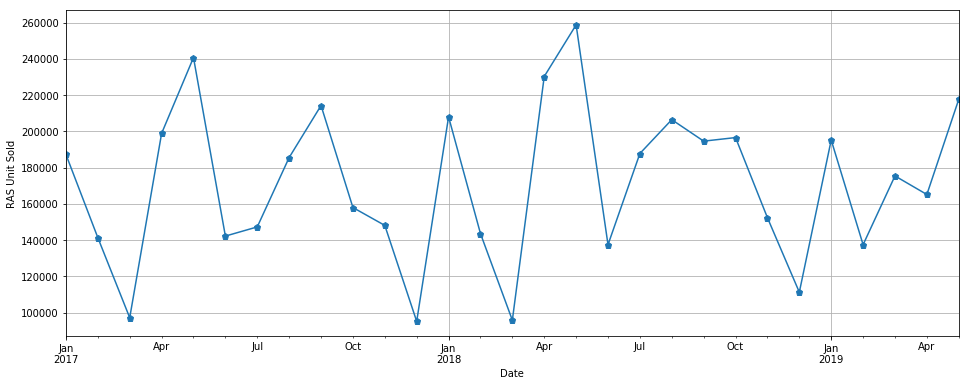

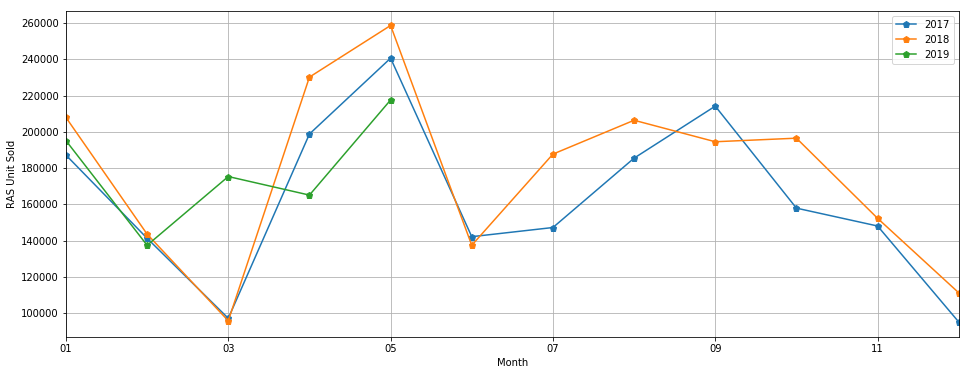

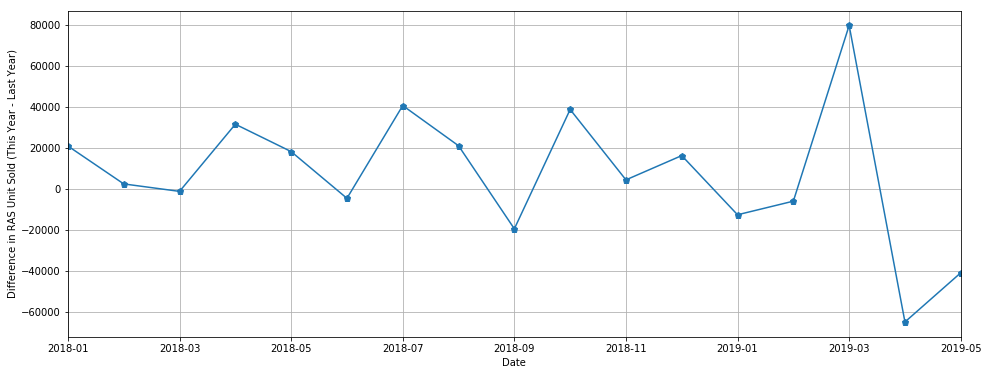

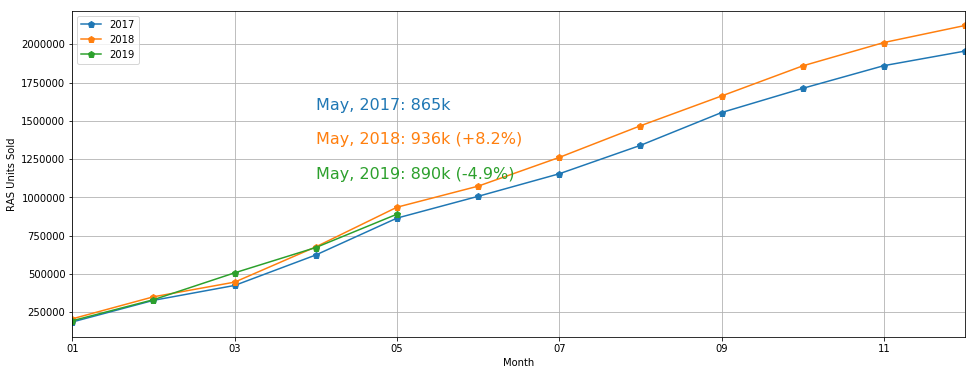

In [34]:
years = [2017, 2018, 2019]
yeardata = {}

localdata = salesdata[salesdata.columns[6:]]

for year in years:
    localyeardata = localdata[[x for x in localdata.columns if x.year == year]]
    sums = localyeardata.sum()
    sums.index = [datetime.strftime(x, "%m") for x in sums.index]
    yeardata[year] = sums

localdata = salesdata[salesdata.columns[6:]]

f, ax1 = plt.subplots(1, 1, figsize=(16,6))
ax1 = localdata.sum().plot(ax=ax1, grid=True, style='-p', ms=7)
ax1.set_ylabel("RAS Unit Sold")
ax1.set_xlabel("Date")

f, ax1 = plt.subplots(1, 1, figsize=(16,6))
ax1 = DataFrame(yeardata).plot(ax=ax1, grid=True, style='-p', ms=7)
ax1.set_ylabel("RAS Unit Sold")
ax1.set_xlabel("Month")


f, ax1 = plt.subplots(1, 1, figsize=(16,6))
diffs = DataFrame(yeardata).diff(axis=1)[[2018, 2019]]
vals = list(diffs[2018].values) + list(diffs[2019].values)
idxs = pd.date_range('2018-01-01','2020-01-01', freq='M').strftime("%Y-%m").tolist()
retval = Series(vals, index=idxs)
retval = retval[~retval.isna()]
ax1 = retval.plot(ax=ax1, grid=True, style='-p', ms=7)
ax1.set_ylabel("Difference in RAS Unit Sold (This Year - Last Year)")
ax1.set_xlabel("Date")

csumdata = {}
for k,v in yeardata.items():
    csumdata[k] = v.cumsum()
csumdf = DataFrame(csumdata)
f, ax1 = plt.subplots(1, 1, figsize=(16,6))
ax1 = csumdf.plot(ax=ax1, grid=True, style='-p', ms=7)
ax1.set_ylabel("RAS Units Sold")
ax1.set_xlabel("Month")

x0 = csumdf[2017].iloc[4]
x1 = csumdf[2018].iloc[4]
x2 = csumdf[2019].iloc[4]

t0 = "May, 2017: {0}k".format(int(x0/1000))
t1 = "May, 2018: {0}k (+{1}%)".format(int(x1/1000), round(100*(x1/x0-1),1))
t2 = "May, 2019: {0}k ({1}%)".format(int(x2/1000), round(100*(x2/x1-1),1))

plt.text(3.0, 1.65e6, t0, {'color': "C0", 'fontsize': 16}, va="top", ha="left")
plt.text(3.0, 1.43e6, t1, {'color': "C1", 'fontsize': 16}, va="top", ha="left")
plt.text(3.0, 1.20e6, t2, {'color': "C2", 'fontsize': 16}, va="top", ha="left")

for k,v in yeardata.items():
    print(k,"{0}M Units Sold".format(round(sum(v)/1e6,2)))
    
csumdf

In [64]:

#csumdf.diff(axis=1)

# Class Sales

In [110]:
accclasses = {}
for account in salesdata["Acct. Sold-To"].unique():
    if ccmap.get(account) is not None:
        val = ccmap[account]
        if val == "PV":
            if accclasses.get(ccmap[account]) is None:
                accclasses[ccmap[account]] = []
            accclasses[ccmap[account]].append(account)
        else:
            if accclasses.get("NonPV") is None:
                accclasses["NonPV"] = []
            accclasses["NonPV"].append(account)            
    else:
        if accclasses.get("NonPV") is None:
            accclasses["NonPV"] = []
        accclasses["NonPV"].append(account)
        
for k,v in accclasses.items():
    print(k,len(v))

NonPV 1570
PV 195


In [111]:
datas = []
for k,v in accclasses.items():
    localdata = salesdata[salesdata["Acct. Sold-To"].isin(v)]
    localdata["Cust.Class"] = k
    datas.append(localdata)
classdata = concat(datas)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [74]:
classdata.shape

(4576, 36)

In [112]:
years = [2017, 2018, 2019]
qtrs  = [1, 2, 3, 4]

custclasssales = {}

yeardata = {}
ccyearmonthdata = {}
ccyeardata = {}
ccyearqtrdata = {}
for custclass,custclassdata in classdata.groupby("Cust.Class"):
    
    #if custclass in ["NA", "GP", "AL"]:
    #    continue
    
    localdata = custclassdata[custclassdata.columns[6:]]
    localdata = localdata.drop("Cust.Class", axis=1)
    localdata = localdata.fillna(0)

    yeardata[custclass] = {}
    for year in years:
        localyeardata = localdata[[x for x in localdata.columns if x.year == year]]
        sums = localyeardata.sum()
        sums.index = [datetime.strftime(x, "%m") for x in sums.index]
        yeardata[custclass][year] = sums    
    
    ccyearmonthdata[custclass] = localdata.sum()
    custclasssales[custclass] = round(localdata.values.sum(),1)
    

    ccyeardata[custclass] = {}
    ccyearqtrdata[custclass] = {}
    
    rdata = {}
    for year in years:
        localyeardata = localdata[[x for x in localdata.columns if x.year == year]]
        localyeardata = localyeardata.fillna(0)
        sales = localyeardata.values.sum()
        rdata["{0}".format(year)] = sales
    ccyeardata[custclass] = rdata

    rdata = {}
    for year in years:
        localyeardata = localdata[[x for x in localdata.columns if x.year == year]]
        for qtr in qtrs:
            if year == 2019 and qtr >= 2:
                break
            localqtrdata = localyeardata[[x for x in localyeardata.columns if pd.Timestamp(x).quarter == qtr]]
            localqtrdata = localqtrdata.fillna(0)
            sales = localqtrdata.values.sum()
            rdata["{0}-Qtr{1}".format(year,qtr)] = sales
    ccyearqtrdata[custclass] = rdata

In [113]:
csums = {}
for region,rdata in yeardata.items():    
    csumdata = {}
    for k,v in rdata.items():
        csumdata[k] = v.cumsum()
    csumdf = DataFrame(csumdata)
    csums[region] = csumdf

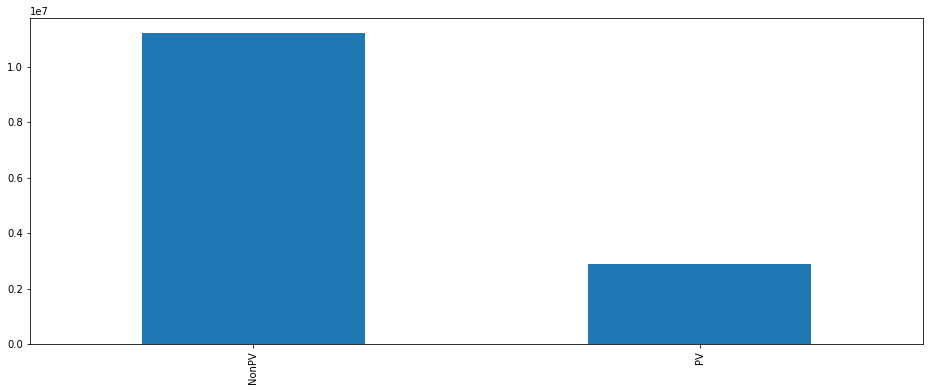

In [114]:
rsums = {}
for k,v in csums.items():
    rsums[k] = v[2018].sum()
rorder = Series(rsums).sort_values(ascending=False)

f, (ax1) = plt.subplots(1, 1, figsize=(16,6))
rorder.plot('bar', ax=ax1)

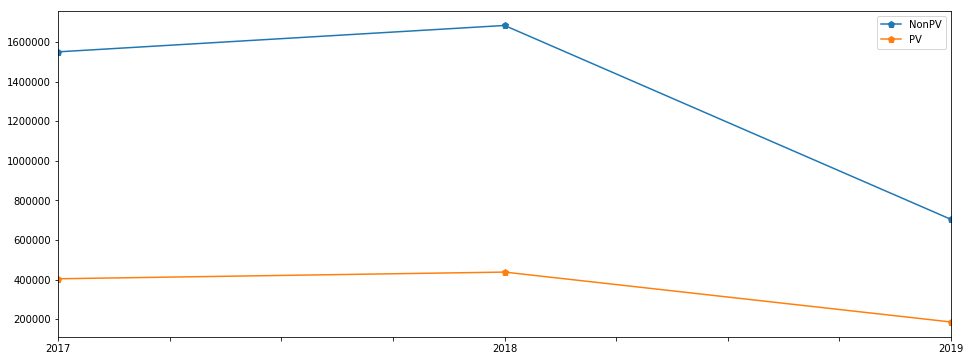

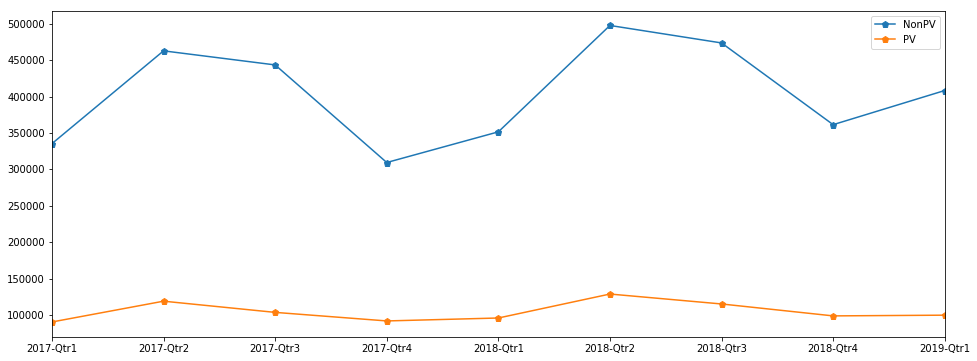

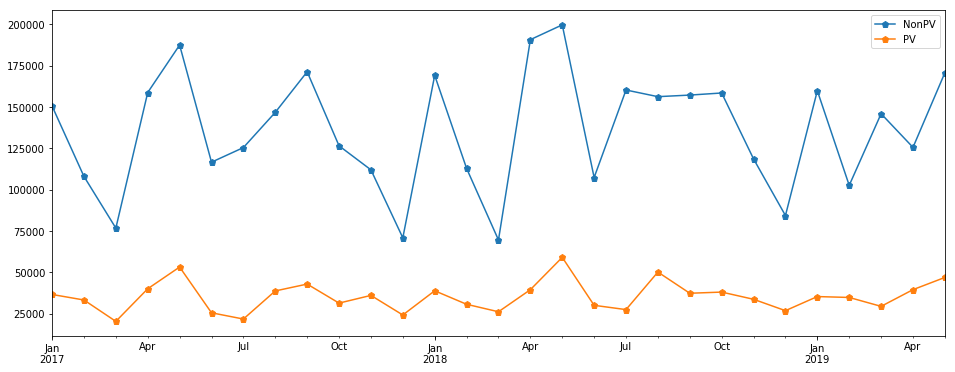

In [115]:
f, (ax1) = plt.subplots(1, 1, figsize=(16,6))
DataFrame(ccyeardata).plot(ax=ax1, legend=True, style='-p', ms=7)
f, (ax1) = plt.subplots(1, 1, figsize=(16,6))
DataFrame(ccyearqtrdata).plot(ax=ax1, legend=True, style='-p', ms=7)
f, (ax1) = plt.subplots(1, 1, figsize=(16,6))
DataFrame(ccyearmonthdata).plot(ax=ax1, legend=True, style='-p', ms=7)

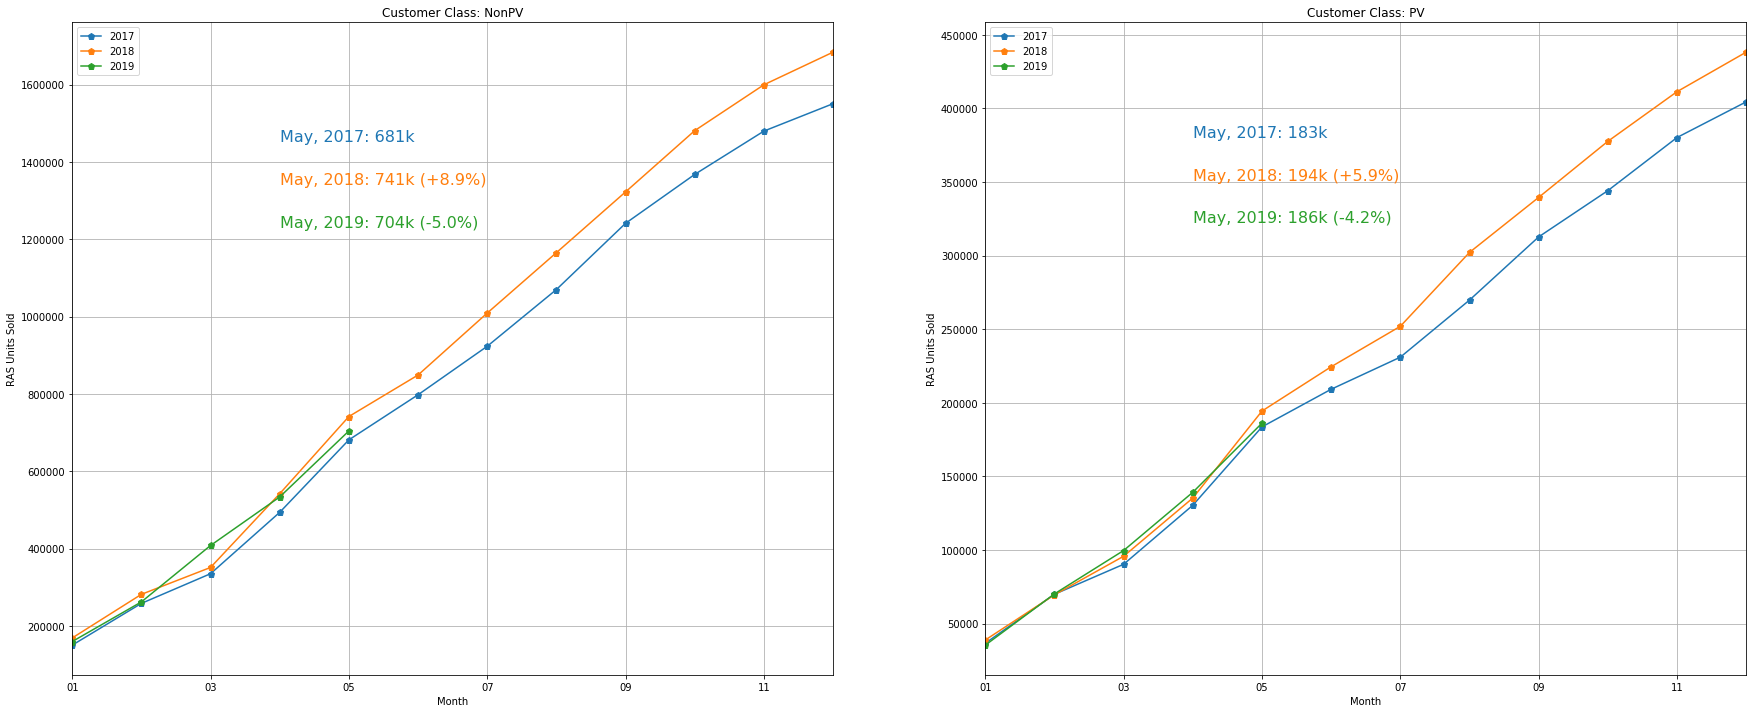

In [116]:
f, axs = plt.subplots(1, len(csums), sharex=True, sharey=False, figsize=(30,12))

ir = 0
for region,csumdf in csums.items():


    axs[ir] = csumdf.plot(ax=axs[ir], legend=True, style='-p', ms=7, grid=True)
    axs[ir].set_ylabel("RAS Units Sold")
    axs[ir].set_title("Customer Class: {0}".format(region))
    axs[ir].set_xlabel("Month")    
    
    if True:
        x0 = csumdf[2017].iloc[4]
        x1 = csumdf[2018].iloc[4]
        x2 = csumdf[2019].iloc[4]

        t0 = "May, 2017: {0}k".format(int(x0/1000))
        t1 = "May, 2018: {0}k (+{1}%)".format(int(x1/1000), round(100*(x1/x0-1),1))
        t2 = "May, 2019: {0}k ({1}%)".format(int(x2/1000), round(100*(x2/x1-1),1))

        axs[ir].text(3.0, 2*x1, t0, {'color': "C0", 'fontsize': 16}, va="top", ha="left")
        axs[ir].text(3.0, 1.85*x1, t1, {'color': "C1", 'fontsize': 16}, va="top", ha="left")
        axs[ir].text(3.0, 1.7*x1, t2, {'color': "C2", 'fontsize': 16}, va="top", ha="left")    
        
    
    ir += 1

In [105]:
ryqdf = DataFrame(ccyearqtrdata)
ryqdf["Qtr Sum"] = ryqdf.sum(axis=1)
ryqdf["Qtr CuSum"] = ryqdf["Qtr Sum"].cumsum()
rsums = ryqdf.sum(axis=0)
rsums.iloc[-1] = None
regsums  = DataFrame(rsums, columns=["Class Sum"]).T
regiondf = ryqdf.append(regsums, ignore_index = False)
regiondf.round(1).style.applymap(color_negative_red)

,#,IA,PV,Qtr Sum,Qtr CuSum
2017-Qtr1,1.95e+05,1.34e+05,9.03e+04,4.19e+05,4.19e+05
2017-Qtr2,3.01e+05,1.53e+05,1.19e+05,5.73e+05,9.93e+05
2017-Qtr3,2.66e+05,1.7e+05,1.04e+05,5.4e+05,1.53e+06
2017-Qtr4,2.01e+05,1.02e+05,9.17e+04,3.94e+05,1.93e+06
2018-Qtr1,2.11e+05,1.33e+05,9.58e+04,4.4e+05,2.37e+06
2018-Qtr2,3.29e+05,1.58e+05,1.29e+05,6.16e+05,2.98e+06
2018-Qtr3,2.87e+05,1.78e+05,1.15e+05,5.8e+05,3.56e+06
2018-Qtr4,2.4e+05,1.13e+05,9.87e+04,4.51e+05,4.01e+06
2019-Qtr1,2.38e+05,1.61e+05,9.97e+04,4.99e+05,4.51e+06
Class Sum,2.27e+06,1.3e+06,9.42e+05,4.51e+06,nan


# Region Sales

In [8]:
years = [2017, 2018, 2019]
qtrs  = [1, 2, 3, 4]

regionsales = {}

yeardata = {}
regyearmonthdata = {}
regyeardata = {}
regyearqtrdata = {}
for region,regiondata in salesdata.groupby("Region Name"):

    if region in ["Consumer House Acct", "LM House Account", "US Retail Regnl Acct", "Latin America", "Not assigned"]:
        continue

    localdata = regiondata[regiondata.columns[6:]]
    localdata = localdata.fillna(0)

    yeardata[region] = {}
    for year in years:
        localyeardata = localdata[[x for x in localdata.columns if x.year == year]]
        sums = localyeardata.sum()
        sums.index = [datetime.strftime(x, "%m") for x in sums.index]
        yeardata[region][year] = sums    
    
    regyearmonthdata[region] = localdata.sum()
    regionsales[region] = round(localdata.values.sum(),1)
    

    regyeardata[region] = {}
    regyearqtrdata[region] = {}
    
    rdata = {}
    for year in years:
        localyeardata = localdata[[x for x in localdata.columns if x.year == year]]
        localyeardata = localyeardata.fillna(0)
        sales = localyeardata.values.sum()
        rdata["{0}".format(year)] = sales
    regyeardata[region] = rdata

    rdata = {}
    for year in years:
        localyeardata = localdata[[x for x in localdata.columns if x.year == year]]
        for qtr in qtrs:
            if year == 2019 and qtr >= 2:
                break
            localqtrdata = localyeardata[[x for x in localyeardata.columns if pd.Timestamp(x).quarter == qtr]]
            localqtrdata = localqtrdata.fillna(0)
            sales = localqtrdata.values.sum()
            rdata["{0}-Qtr{1}".format(year,qtr)] = sales
    regyearqtrdata[region] = rdata

In [9]:
csums = {}
for region,rdata in yeardata.items():    
    csumdata = {}
    for k,v in rdata.items():
        csumdata[k] = v.cumsum()
    csumdf = DataFrame(csumdata)
    csums[region] = csumdf

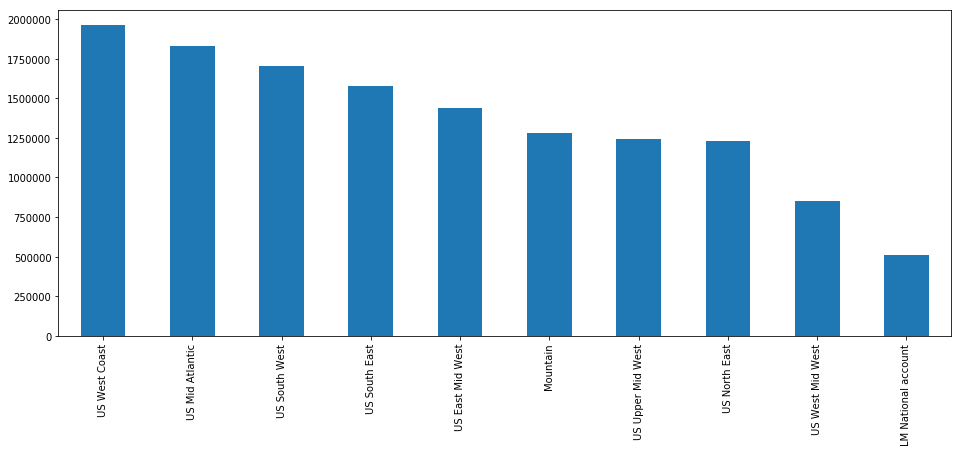

In [10]:
rsums = {}
for k,v in csums.items():
    rsums[k] = v[2018].sum()
rorder = Series(rsums).sort_values(ascending=False)

f, (ax1) = plt.subplots(1, 1, figsize=(16,6))
rorder.plot('bar', ax=ax1)

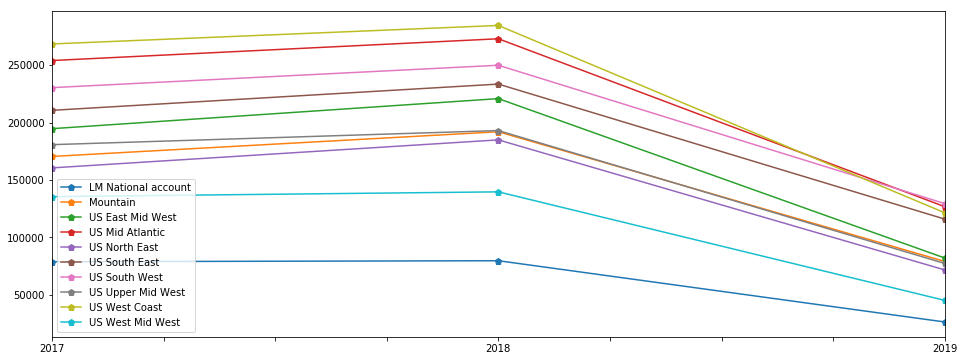

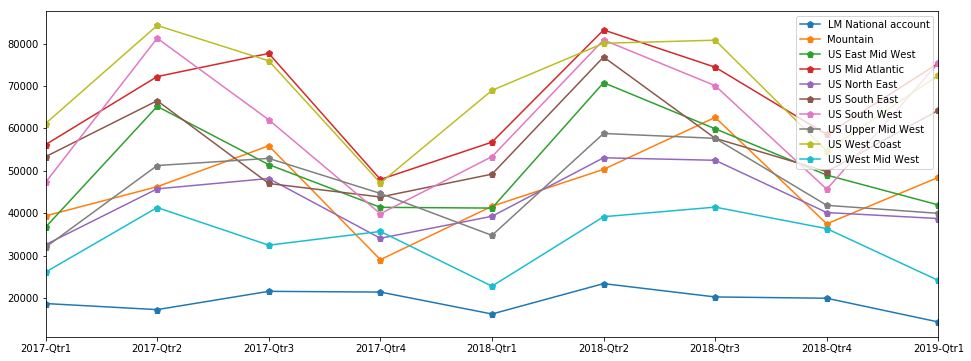

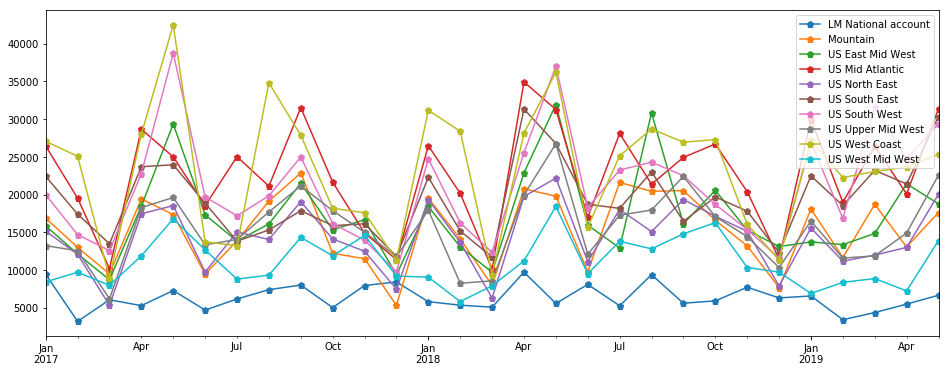

In [11]:
f, (ax1) = plt.subplots(1, 1, figsize=(16,6))
DataFrame(regyeardata).plot(ax=ax1, legend=True, style='-p', ms=7)
f, (ax1) = plt.subplots(1, 1, figsize=(16,6))
DataFrame(regyearqtrdata).plot(ax=ax1, legend=True, style='-p', ms=7)
f, (ax1) = plt.subplots(1, 1, figsize=(16,6))
DataFrame(regyearmonthdata).plot(ax=ax1, legend=True, style='-p', ms=7)

## Not Assigned

In [39]:
csums

{'LM National account':        2017     2018     2019
 01   9441.0   5802.0   6562.0
 02  12634.0  11144.0   9976.0
 03  18686.0  16217.0  14339.0
 04  23965.0  25934.0  19823.0
 05  31248.0  31509.0  26479.0
 06  35938.0  39600.0      NaN
 07  42099.0  44864.0      NaN
 08  49498.0  54244.0      NaN
 09  57501.0  59841.0      NaN
 10  62524.0  65755.0      NaN
 11  70471.0  73471.0      NaN
 12  78891.0  79775.0      NaN, 'Mountain':         2017      2018     2019
 01   16871.0   19530.0  18083.0
 02   29872.0   33656.0  29738.0
 03   39360.0   41625.0  48439.0
 04   58784.0   62380.0  61501.0
 05   76133.0   82179.0  79126.0
 06   85598.0   91949.0      NaN
 07   99476.0  113556.0      NaN
 08  118605.0  133998.0      NaN
 09  141477.0  154531.0      NaN
 10  153698.0  171137.0      NaN
 11  165201.0  184338.0      NaN
 12  170511.0  192011.0      NaN, 'US East Mid West':         2017      2018     2019
 01   15849.0   18424.0  13722.0
 02   27980.0   31486.0  27090.0
 03   36692.0 

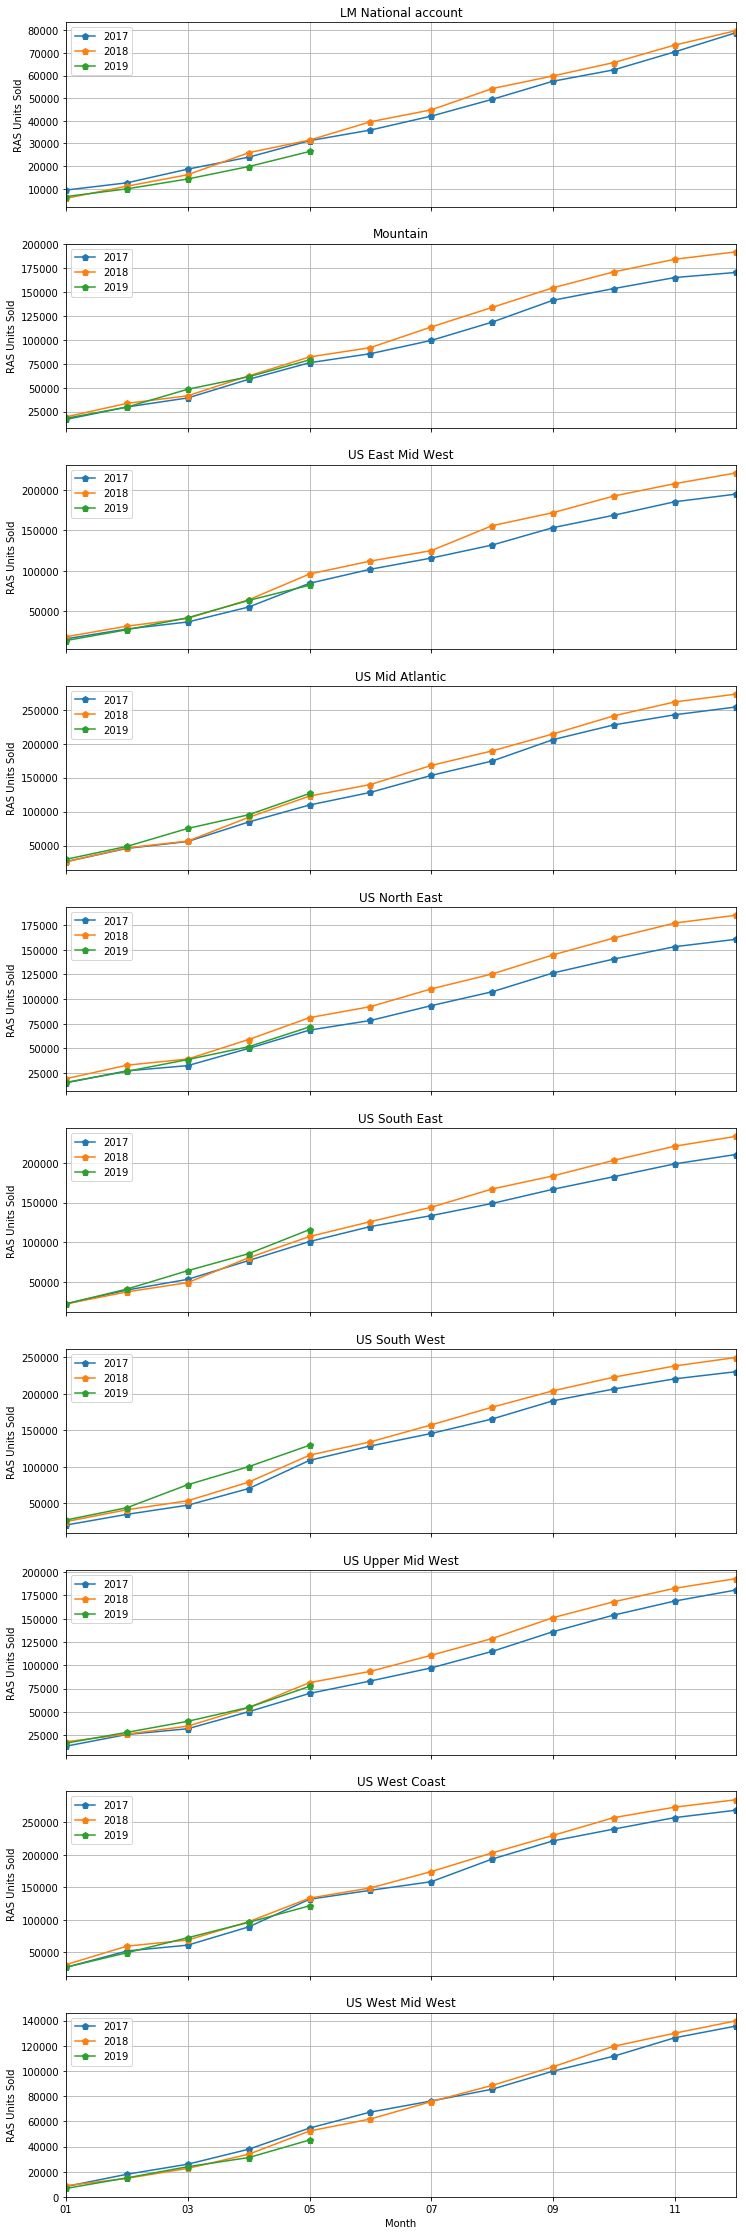

In [42]:
f, axs = plt.subplots(len(csums), 1, sharex=True, figsize=(12,40))

ir = 0
for region,csumdf in csums.items():


    axs[ir] = csumdf.plot(ax=axs[ir], legend=True, style='-p', ms=7, grid=True)
    axs[ir].set_ylabel("RAS Units Sold")
    axs[ir].set_title(region)
    axs[ir].set_xlabel("Month")    
    
    if False:
        x0 = csumdf[2017].iloc[4]
        x1 = csumdf[2018].iloc[4]
        x2 = csumdf[2019].iloc[4]

        t0 = "May, 2017: {0}k".format(int(x0/1000))
        t1 = "May, 2018: {0}k (+{1}%)".format(int(x1/1000), round(100*(x1/x0-1),1))
        t2 = "May, 2019: {0}k ({1}%)".format(int(x2/1000), round(100*(x2/x1-1),1))

        plt.text(3.0, 1.5*x1, t0, {'color': "C0", 'fontsize': 16}, va="top", ha="left")
        plt.text(3.0, 1.3*x1, t1, {'color': "C1", 'fontsize': 16}, va="top", ha="left")
        plt.text(3.0, 1.1*x1, t2, {'color': "C2", 'fontsize': 16}, va="top", ha="left")    
        
    
    ir += 1

In [43]:
ryqdf = DataFrame(regyearqtrdata)
ryqdf["Qtr Sum"] = ryqdf.sum(axis=1)
ryqdf["Qtr CuSum"] = ryqdf["Qtr Sum"].cumsum()
rsums = ryqdf.sum(axis=0)
rsums.iloc[-1] = None
regsums  = DataFrame(rsums, columns=["Reg Sum"]).T
regiondf = ryqdf.append(regsums, ignore_index = False)
regiondf.round(1).style.applymap(color_negative_red)

,LM National account,Mountain,US East Mid West,US Mid Atlantic,US North East,US South East,US South West,US Upper Mid West,US West Coast,US West Mid West,Qtr Sum,Qtr CuSum
2017-Qtr1,1.87e+04,3.94e+04,3.67e+04,5.62e+04,3.26e+04,5.33e+04,4.73e+04,3.2e+04,6.11e+04,2.61e+04,4.03e+05,4.03e+05
2017-Qtr2,1.73e+04,4.62e+04,6.52e+04,7.22e+04,4.57e+04,6.65e+04,8.12e+04,5.12e+04,8.43e+04,4.13e+04,5.71e+05,9.74e+05
2017-Qtr3,2.16e+04,5.59e+04,5.14e+04,7.77e+04,4.82e+04,4.7e+04,6.2e+04,5.29e+04,7.59e+04,3.24e+04,5.25e+05,1.5e+06
2017-Qtr4,2.14e+04,2.9e+04,4.14e+04,4.79e+04,3.41e+04,4.38e+04,3.99e+04,4.47e+04,4.71e+04,3.57e+04,3.85e+05,1.88e+06
2018-Qtr1,1.62e+04,4.16e+04,4.12e+04,5.68e+04,3.93e+04,4.92e+04,5.33e+04,3.48e+04,6.9e+04,2.28e+04,4.24e+05,2.31e+06
2018-Qtr2,2.34e+04,5.03e+04,7.08e+04,8.32e+04,5.31e+04,7.68e+04,8.08e+04,5.88e+04,8.01e+04,3.92e+04,6.16e+05,2.92e+06
2018-Qtr3,2.02e+04,6.26e+04,5.99e+04,7.44e+04,5.25e+04,5.76e+04,7.01e+04,5.76e+04,8.08e+04,4.14e+04,5.77e+05,3.5e+06
2018-Qtr4,1.99e+04,3.75e+04,4.9e+04,5.86e+04,4.01e+04,4.98e+04,4.56e+04,4.18e+04,5.47e+04,3.63e+04,4.33e+05,3.94e+06
2019-Qtr1,1.43e+04,4.84e+04,4.19e+04,7.53e+04,3.87e+04,6.42e+04,7.54e+04,4e+04,7.25e+04,2.41e+04,4.95e+05,4.43e+06
Reg Sum,1.73e+05,4.11e+05,4.57e+05,6.02e+05,3.84e+05,5.08e+05,5.56e+05,4.14e+05,6.25e+05,2.99e+05,4.43e+06,nan


In [44]:
ryqdf = DataFrame(regyearqtrdata).diff()
ryqdf["Qtr Sum"] = ryqdf.sum(axis=1)
ryqdf["Qtr CuSum"] = ryqdf["Qtr Sum"].cumsum()
rsums = ryqdf.sum(axis=0)
rsums.iloc[-1] = None
regsums  = DataFrame(rsums, columns=["Reg Sum"]).T
regiondf = ryqdf.append(regsums, ignore_index = False)
regiondf.round(1).style.applymap(color_negative_red).apply(highlight_max)

,LM National account,Mountain,US East Mid West,US Mid Atlantic,US North East,US South East,US South West,US Upper Mid West,US West Coast,US West Mid West,Qtr Sum,Qtr CuSum
2017-Qtr1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0,0
2017-Qtr2,-1.43e+03,6.88e+03,2.85e+04,1.6e+04,1.32e+04,1.32e+04,3.4e+04,1.93e+04,2.31e+04,1.52e+04,1.68e+05,1.68e+05
2017-Qtr3,4.31e+03,9.64e+03,-1.37e+04,5.45e+03,2.44e+03,-1.95e+04,-1.92e+04,1.68e+03,-8.34e+03,-8.87e+03,-4.62e+04,1.22e+05
2017-Qtr4,-173,-2.68e+04,-1.01e+04,-2.97e+04,-1.41e+04,-3.19e+03,-2.22e+04,-8.26e+03,-2.88e+04,3.23e+03,-1.4e+05,-1.83e+04
2018-Qtr1,-5.17e+03,1.26e+04,-179,8.80e+03,5.18e+03,5.39e+03,1.35e+04,-9.89e+03,2.19e+04,-1.29e+04,3.91e+04,2.08e+04
2018-Qtr2,7.17e+03,8.7e+03,2.96e+04,2.64e+04,1.38e+04,2.76e+04,2.75e+04,2.4e+04,1.11e+04,1.64e+04,1.92e+05,2.13e+05
2018-Qtr3,-3.14e+03,1.23e+04,-1.09e+04,-8.78e+03,-592,-1.92e+04,-1.08e+04,-1.15e+03,731,2.26e+03,-3.92e+04,1.74e+05
2018-Qtr4,-307,-2.51e+04,-1.09e+04,-1.59e+04,-1.23e+04,-7.84e+03,-2.44e+04,-1.58e+04,-2.61e+04,-5.07e+03,-1.44e+05,3.02e+04
2019-Qtr1,-5.6e+03,1.1e+04,-7.04e+03,1.68e+04,-1.42e+03,1.44e+04,2.98e+04,-1.89e+03,1.78e+04,-1.22e+04,6.16e+04,9.18e+04
Reg Sum,-4.35e+03,9.08e+03,5.25e+03,1.92e+04,6.16e+03,1.09e+04,2.81e+04,7.98e+03,1.14e+04,-1.97e+03,9.18e+04,nan


In [45]:
ryqdf = DataFrame(regyearmonthdata).diff()
ryqdf["Month Sum"] = ryqdf.sum(axis=1)
ryqdf["Month CuSum"] = ryqdf["Month Sum"].cumsum()
rsums = ryqdf.sum(axis=0)
rsums.iloc[-1] = None
regsums  = DataFrame(rsums, columns=["Reg Sum"]).T
regiondf = ryqdf.append(regsums, ignore_index = False)
regiondf.round(1).style.applymap(color_negative_red).apply(highlight_max)

,LM National account,Mountain,US East Mid West,US Mid Atlantic,US North East,US South East,US South West,US Upper Mid West,US West Coast,US West Mid West,Month Sum,Month CuSum
2017-01-01 00:00:00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0,0
2017-02-01 00:00:00,-6.25e+03,-3.87e+03,-3.72e+03,-6.91e+03,-3.06e+03,-5.01e+03,-5.3e+03,-680,-1.98e+03,1.27e+03,-3.55e+04,-3.55e+04
2017-03-01 00:00:00,2.86e+03,-3.51e+03,-3.42e+03,-9.34e+03,-6.77e+03,-3.93e+03,-2.11e+03,-6.37e+03,-1.61e+04,-1.72e+03,-5.04e+04,-8.59e+04
2017-04-01 00:00:00,-773,9.94e+03,9.77e+03,1.85e+04,1.21e+04,1.02e+04,1.02e+04,1.21e+04,1.9e+04,3.9e+03,1.05e+05,1.91e+04
2017-05-01 00:00:00,2e+03,-2.08e+03,1.09e+04,-3.66e+03,1.08e+03,254,1.6e+04,1.34e+03,1.45e+04,4.9e+03,4.52e+04,6.43e+04
2017-06-01 00:00:00,-2.59e+03,-7.88e+03,-1.2e+04,-6.47e+03,-8.81e+03,-5.09e+03,-1.9e+04,-6.28e+03,-2.88e+04,-4.12e+03,-1.01e+05,-3.68e+04
2017-07-01 00:00:00,1.47e+03,4.41e+03,-3.50e+03,6.5e+03,5.33e+03,-5.04e+03,-2.51e+03,718,-507,-3.86e+03,3e+03,-3.38e+04
2017-08-01 00:00:00,1.24e+03,5.25e+03,2.29e+03,-3.92e+03,-1.01e+03,1.48e+03,2.64e+03,3.64e+03,2.16e+04,517,3.37e+04,-95
2017-09-01 00:00:00,604,3.74e+03,5.38e+03,1.04e+04,5.02e+03,2.55e+03,5.15e+03,3.46e+03,-6.95e+03,5.01e+03,3.44e+04,3.43e+04
2017-10-01 00:00:00,-2.98e+03,-1.07e+04,-6.15e+03,-9.86e+03,-4.94e+03,-1.97e+03,-8.82e+03,-3.29e+03,-9.68e+03,-2.44e+03,-6.08e+04,-2.65e+04


# Channel Sales

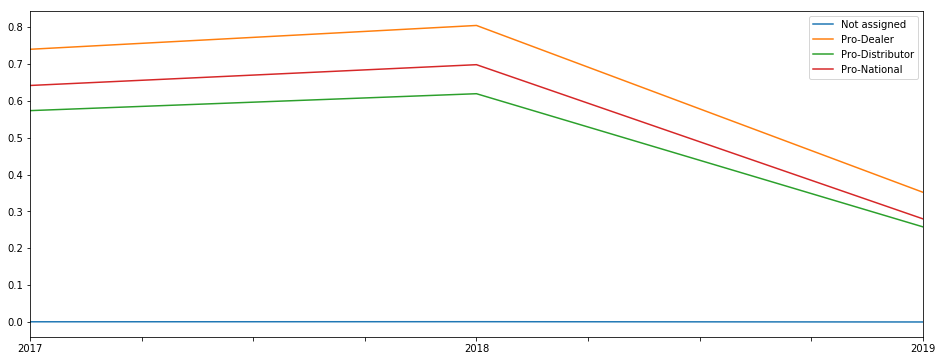

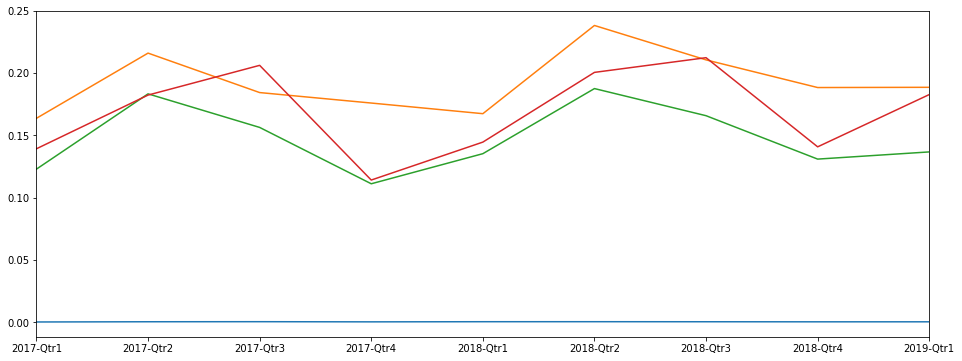

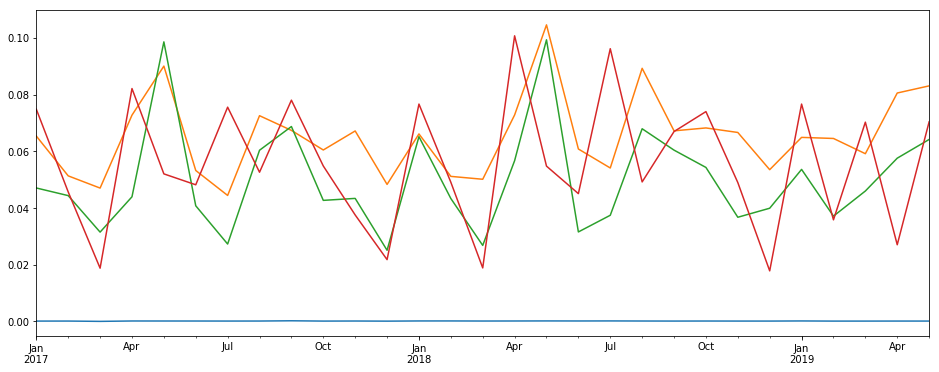

In [107]:
years = [2017, 2018, 2019]
qtrs  = [1, 2, 3, 4]

for channel,channeldata in salesdata.groupby("Acct. Channel"):
    
    if channel in ["Consumer Chamberlain", "Internal", "Ret-Distributors"]:
        continue
    
    localdata = channeldata[channeldata.columns[6:]]

channelsales = {}
chanyearmonthdata = {}
chanyeardata = {}
chanyearqtrdata = {}
for channel,channeldata in salesdata.groupby("Acct. Channel"):

    if channel in ["Consumer Chamberlain", "Internal", "Ret-Distributors"]:
        continue

    localdata = channeldata[channeldata.columns[6:]]
    localdata = localdata.fillna(0)
    chanyearmonthdata[channel] = localdata.sum()/1e6
    channelsales[channel] = round(localdata.values.sum()/1e6,1)
    

    chanyeardata[channel] = {}
    chanyearqtrdata[channel] = {}
    
    rdata = {}
    for year in years:
        localyeardata = localdata[[x for x in localdata.columns if x.year == year]]
        localyeardata = localyeardata.fillna(0)
        sales = localyeardata.values.sum()/1e6
        rdata["{0}".format(year)] = sales
    chanyeardata[channel] = rdata

    rdata = {}
    for year in years:
        localyeardata = localdata[[x for x in localdata.columns if x.year == year]]
        for qtr in qtrs:
            if year == 2019 and qtr >= 2:
                break
            localqtrdata = localyeardata[[x for x in localyeardata.columns if pd.Timestamp(x).quarter == qtr]]
            localqtrdata = localqtrdata.fillna(0)
            sales = localqtrdata.values.sum()/1e6
            rdata["{0}-Qtr{1}".format(year,qtr)] = sales
    chanyearqtrdata[channel] = rdata
    
    
f, (ax1) = plt.subplots(1, 1, figsize=(16,6))
DataFrame(chanyeardata).plot(ax=ax1, legend=True)
f, (ax1) = plt.subplots(1, 1, figsize=(16,6))
DataFrame(chanyearqtrdata).plot(ax=ax1, legend=False)
f, (ax1) = plt.subplots(1, 1, figsize=(16,6))
DataFrame(chanyearmonthdata).plot(ax=ax1, legend=False)

In [108]:
ryqdf = DataFrame(chanyearqtrdata)
ryqdf["Qtr Sum"] = ryqdf.sum(axis=1)
ryqdf["Qtr CuSum"] = ryqdf["Qtr Sum"].cumsum()
rsums = ryqdf.sum(axis=0)
rsums.iloc[-1] = None
regsums  = DataFrame(rsums, columns=["Chan Sum"]).T
regiondf = ryqdf.append(regsums, ignore_index = False)
regiondf.round(1).style.applymap(color_negative_red)

,Not assigned,Pro-Dealer,Pro-Distributor,Pro-National,Qtr Sum,Qtr CuSum
2017-Qtr1,0,0.2,0.1,0.1,0.4,0.4
2017-Qtr2,0,0.2,0.2,0.2,0.6,1
2017-Qtr3,0,0.2,0.2,0.2,0.5,1.6
2017-Qtr4,0,0.2,0.1,0.1,0.4,2
2018-Qtr1,0,0.2,0.1,0.1,0.4,2.4
2018-Qtr2,0,0.2,0.2,0.2,0.6,3
2018-Qtr3,0,0.2,0.2,0.2,0.6,3.6
2018-Qtr4,0,0.2,0.1,0.1,0.5,4.1
2019-Qtr1,0,0.2,0.1,0.2,0.5,4.6
Chan Sum,0,1.7,1.3,1.5,4.6,nan


In [109]:
ryqdf = DataFrame(chanyearqtrdata).diff()
ryqdf["Qtr Sum"] = ryqdf.sum(axis=1)
ryqdf["Qtr CuSum"] = ryqdf["Qtr Sum"].cumsum()
rsums = ryqdf.sum(axis=0)
rsums.iloc[-1] = None
regsums  = DataFrame(rsums, columns=["Chan Sum"]).T
regiondf = ryqdf.append(regsums, ignore_index = False)
regiondf.round(1).style.applymap(color_negative_red).apply(highlight_max)

,Not assigned,Pro-Dealer,Pro-Distributor,Pro-National,Qtr Sum,Qtr CuSum
2017-Qtr1,nan,nan,nan,nan,0,0
2017-Qtr2,0,0.1,0.1,0,0.2,0.2
2017-Qtr3,0,-0,-0,0,-0,0.1
2017-Qtr4,-0,-0,-0,-0.1,-0.1,-0
2018-Qtr1,0,-0,0,0,0,0
2018-Qtr2,0,0.1,0.1,0.1,0.2,0.2
2018-Qtr3,-0,-0,-0,0,-0,0.2
2018-Qtr4,-0,-0,-0,-0.1,-0.1,0
2019-Qtr1,0,0,0,0,0,0.1
Chan Sum,0,0,0,0,0.1,nan


In [ ]:
ryqdf = DataFrame(chanyearmonthdata).diff()
ryqdf["Month Sum"] = ryqdf.sum(axis=1)
ryqdf["Month CuSum"] = ryqdf["Month Sum"].cumsum()
rsums = ryqdf.sum(axis=0)
rsums.iloc[-1] = None
regsums  = DataFrame(rsums, columns=["Chan Sum"]).T
regiondf = ryqdf.append(regsums, ignore_index = False)
regiondf.round(1).style.applymap(color_negative_red).apply(highlight_max)

# Account Sales

In [ ]:
majoraccounts = read_excel("Top 75 Distributors.xlsx")
majacc = list(majoraccounts.iloc[:,1].values)

In [ ]:
totalsales = {}
nKeep = 10

majoraccountdata = salesdata[salesdata["Acct. Sold-To"].isin(majacc)]
for account,accountdata in majoraccountdata.groupby("Acct. Sold-To"):
    
    if account in ["Consumer Chamberlain", "Internal", "Ret-Distributors"]:
        continue
    
    totalsales[account] = accountdata[accountdata.columns[6:]].fillna(0).values.sum()/1e6

verymajacc = list(Series(totalsales).sort_values(ascending=True)[-1*nKeep:].index)
print(verymajacc)
majoraccountdata = majoraccountdata[majoraccountdata["Acct. Sold-To"].isin(verymajacc)]

totalsales = {}
for account,accountdata in majoraccountdata.groupby("Acct. Sold-To"):
    
    if account in ["Consumer Chamberlain", "Internal", "Ret-Distributors"]:
        continue
    
    totalsales[account] = accountdata[accountdata.columns[6:]].fillna(0).values.sum()/1e6
totalsales = Series(totalsales).sort_values(ascending=True)

In [ ]:
f, (ax1) = plt.subplots(1, 1, figsize=(16,6))
totalsales.plot('barh')

In [ ]:
years = [2017, 2018, 2019]
qtrs  = [1, 2, 3, 4]

plotdata = {}
for account,accountdata in majoraccountdata.groupby("Acct. Sold-To"):
    
    if account in ["Consumer Chamberlain", "Internal", "Ret-Distributors"]:
        continue
    
    localdata = accountdata[accountdata.columns[6:]]
    plotdata[account] = localdata.sum()

accountsales = {}
accyearmonthdata = {}
accyeardata = {}
accyearqtrdata = {}
for account,accountdata in majoraccountdata.groupby("Acct. Sold-To"):

    if account in ["Consumer Chamberlain", "Internal", "Ret-Distributors"]:
        continue

    localdata = accountdata[accountdata.columns[6:]]
    localdata = localdata.fillna(0)
    accyearmonthdata[account] = localdata.sum()/1e6
    accountsales[account] = round(localdata.values.sum()/1e6,1)
    

    accyeardata[account] = {}
    accyearqtrdata[account] = {}
    
    rdata = {}
    for year in years:
        localyeardata = localdata[[x for x in localdata.columns if x.year == year]]
        localyeardata = localyeardata.fillna(0)
        sales = localyeardata.values.sum()/1e6
        rdata["{0}".format(year)] = sales
    accyeardata[account] = rdata

    rdata = {}
    for year in years:
        localyeardata = localdata[[x for x in localdata.columns if x.year == year]]
        for qtr in qtrs:
            if year == 2019 and qtr >= 2:
                break
            localqtrdata = localyeardata[[x for x in localyeardata.columns if pd.Timestamp(x).quarter == qtr]]
            localqtrdata = localqtrdata.fillna(0)
            sales = localqtrdata.values.sum()/1e6
            rdata["{0}-Qtr{1}".format(year,qtr)] = sales
    accyearqtrdata[account] = rdata
    
    
f, (ax1) = plt.subplots(1, 1, figsize=(16,6))
DataFrame(accyeardata).plot(ax=ax1, legend=True)
f, (ax1) = plt.subplots(1, 1, figsize=(16,6))
DataFrame(accyearqtrdata).plot(ax=ax1, legend=True)
f, (ax1) = plt.subplots(1, 1, figsize=(16,6))
DataFrame(accyearmonthdata).plot(ax=ax1, legend=True)

In [ ]:
ryqdf = DataFrame(accyearqtrdata)
ryqdf["Qtr Sum"] = ryqdf.sum(axis=1)
ryqdf["Qtr CuSum"] = ryqdf["Qtr Sum"].cumsum()
rsums = ryqdf.sum(axis=0)
rsums.iloc[-1] = None
regsums  = DataFrame(rsums, columns=["Accnt Sum"]).T
regiondf = ryqdf.append(regsums, ignore_index = False)
regiondf.round(1).style.applymap(color_negative_red)

In [ ]:
ryqdf = DataFrame(accyearqtrdata).diff()
ryqdf["Qtr Sum"] = ryqdf.sum(axis=1)
ryqdf["Qtr CuSum"] = ryqdf["Qtr Sum"].cumsum()
rsums = ryqdf.sum(axis=0)
rsums.iloc[-1] = None
regsums  = DataFrame(rsums, columns=["Accnt Sum"]).T
regiondf = ryqdf.append(regsums, ignore_index = False)
regiondf.round(1).style.applymap(color_negative_red).apply(highlight_max)

In [ ]:
ryqdf = DataFrame(accyearmonthdata).diff()
ryqdf["Month Sum"] = ryqdf.sum(axis=1)
ryqdf["Month CuSum"] = ryqdf["Month Sum"].cumsum()
rsums = ryqdf.sum(axis=0)
rsums.iloc[-1] = None
regsums  = DataFrame(rsums, columns=["Accnt Sum"]).T
regiondf = ryqdf.append(regsums, ignore_index = False)
regiondf.round(1).style.applymap(color_negative_red).apply(highlight_max)

In [ ]:
## Look at Units vs Sales
## Look year-over-year
## What are the not assigned channels and regions (Defered reveve)

In [145]:
from scipy import stats
import numpy as np
from numpy import sqrt

In [164]:
#x = np.linspace(-15, 15, 100)
x = [95, 56, 56, 76, 76]
avg = sum(x)/5
r = stats.norm.rvs(loc=avg, scale=sqrt(avg), size=10000)
stats.ks_2samp(x, r).pvalue
#stats.kstest(x, 'norm').pvalue


0.4063671465816169

In [163]:
r

array([68.69841091, 82.51639131, 65.11725976, ..., 94.23894937,
       54.6342152 , 79.15586482])

In [144]:
x

array([41.90185675, 41.97720994, 49.23767826, 55.70082885, 31.20903146,
       44.90373978, 53.90350587, 53.36962402, 38.47559373, 44.12634818,
       44.61987903, 51.36504376, 49.75889418, 57.06905252, 51.04882074,
       48.22414919, 46.75419349, 38.11032452, 45.01731258, 44.7587069 ,
       53.94971205, 51.14355378, 41.96327304, 31.53790482, 47.6178258 ,
       48.99018062, 54.66740856, 48.65181591, 56.94229085, 59.92821035,
       40.86283686, 53.81056883, 43.31013168, 48.98007892, 64.45546051,
       59.83409533, 57.91497406, 58.28492139, 47.90438541, 44.77788424,
       47.78437509, 57.91501378, 42.37327814, 52.03489495, 55.75667347,
       36.99578934, 52.9171624 , 59.35291805, 61.46318435, 61.58870302,
       31.08808474, 44.4632297 , 64.95174026, 61.81368163, 63.44133701,
       48.81382161, 51.88554199, 51.61186086, 54.94554997, 45.10213154,
       52.12764357, 50.83969646, 52.62870049, 53.00663138, 52.33362744,
       46.27754434, 53.56973432, 45.80522532, 48.73576151, 52.55